In [1]:
import numpy as np
import cv2
from matplotlib import __version__ as plt_version
import matplotlib.pyplot as plt
import sys
import os
os.chdir("../")
print("cwd", os.getcwd())
from importlib import reload
import os

print("python", sys.version_info)
print("numpy", np.__version__)
print("cv2", cv2.__version__) # type: ignore
print("matplotlib", matplotlib.__version__) # type: ignore
os.chdir("..")
print("cwd", os.getcwd())

cwd /Users/jun/codes/SpectraSpark
python sys.version_info(major=3, minor=10, micro=13, releaselevel='final', serial=0)
numpy 1.25.2
cv2 4.8.0
matplotlib 3.7.2


In [2]:
import Saxs2dProfile as s2p
import Saxs1dProfile as s1p
import XafsData as xd
import util
reload(s2p)
reload(s1p)
reload(xd)
reload(util)
print(s2p.__version__)
print(s1p.__version__)
print(xd.__version__)
print(util.__version__)

0.0.26
0.0.15
0.1.0
0.0.1


In [ ]:
# center = (714.920, 107.247)
# dir = "testdata/s202/XAFSisoA02/001"
# for file in util.listFiles(dir, ext=".tif"):
#     print(f"processing {file}...", end="")
#     file = os.path.join(dir, file)
#     profile = s2p.Saxs2dProfile.load_tiff(file)
#     profile.auto_mask_invalid()
#     profile.center = center
#     i, bins = profile.radial_average(dr=1.0)
#     r = (bins[:-1] + bins[1:]) / 2
#     dist = file.replace(".tif", ".csv")
#     header = "\n".join([f"src,{file}", f"center,({center[0]}, {center[1]})", "r[px],i"])
#     data = np.vstack([r, i]).T
#     np.savetxt(dist, data, delimiter=",", header=header)
#     print("done")

In [3]:
s202_isoA02_001 = s1p.DafsData("testdata/s202/XAFSisoA02/001", "../isoA02_001.dat", xafscols=(4, 5))
s202_isoA02_001.loadStdinfo("../../Static/stdinfo.csv")

In [26]:
_M = 2.1018e-4
r2theta = lambda r: np.arctan(r*_M) / 2 #[rad]
theta2r = lambda theta: np.tan(2*theta) / _M #[px]

def r2q(r, e):
    # e: energy [keV]
    return 4*np.pi*e*np.sin(r2theta(r)) / 1.2398 #[1/nm]

def q2r(q, e):
    # e: energy [keV]
    return theta2r(np.arcsin(q*1.2398/(4*np.pi*e))) #[px]

print(q2r(3.86, np.array([9200,9600,10000,10400])/1000))

[394.9101821  378.3759227  363.17343115 349.14772674]


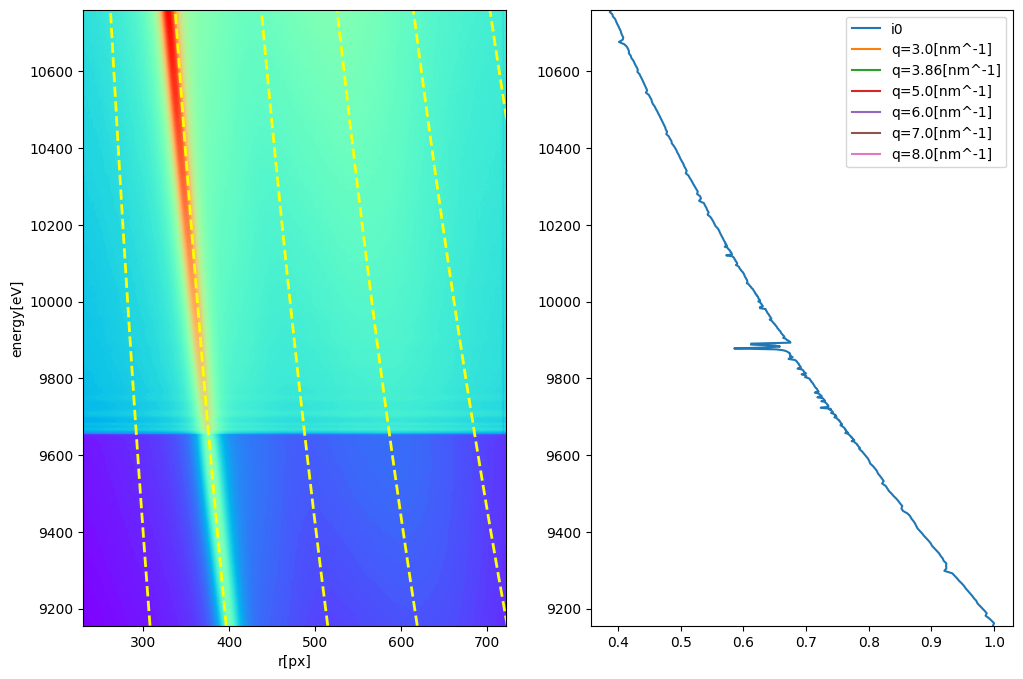

In [27]:
q = np.array([3.0, 3.86, 5, 6, 7, 8])
# q = np.array([3.0, 5, 6, 7, 8])

fig, axs = plt.subplots(1,2,figsize=(12,8))
ax = axs[0]
ax = s202_isoA02_001.heatmap(ax, levels=200)

for qi in q:
    # _q = np.full_like(s202_isoA02_001.energy, qi)
    # _r = s202_isoA02_001.q2r(_q, s202_isoA02_001.energy)
    _r = q2r(qi, s202_isoA02_001.energy/1e3)
    ax.plot(
        _r,s202_isoA02_001.energy, label=f"q={qi}[nm^-1]", color="yellow", linewidth=2,
        linestyle="dashed"
    )
ax.set_xlim(s202_isoA02_001.r[0], s202_isoA02_001.r[-1])

ax = axs[1]
_tr = s202_isoA02_001.xafsfile.data["tr"] / s202_isoA02_001.i0
_fl = s202_isoA02_001.xafsfile.data["fl"] / s202_isoA02_001.i0
ax.plot(s202_isoA02_001.i0/s202_isoA02_001.i0.max(), s202_isoA02_001.energy, label="i0")
ax.plot(_tr/_tr.max(), s202_isoA02_001.energy, label="tr")
ax.plot(_fl/_fl.max(), s202_isoA02_001.energy, label="fl")
for qi in q:
    _i = s202_isoA02_001.q_slice(qi)
    _i = _i / _i.max()
    ax.plot(
        _i, s202_isoA02_001.energy, label=f"q={qi}[nm^-1]"
    )
ax.legend()

for ax in axs:
    ax.set_ylim(s202_isoA02_001.energy[0], s202_isoA02_001.energy[-1])

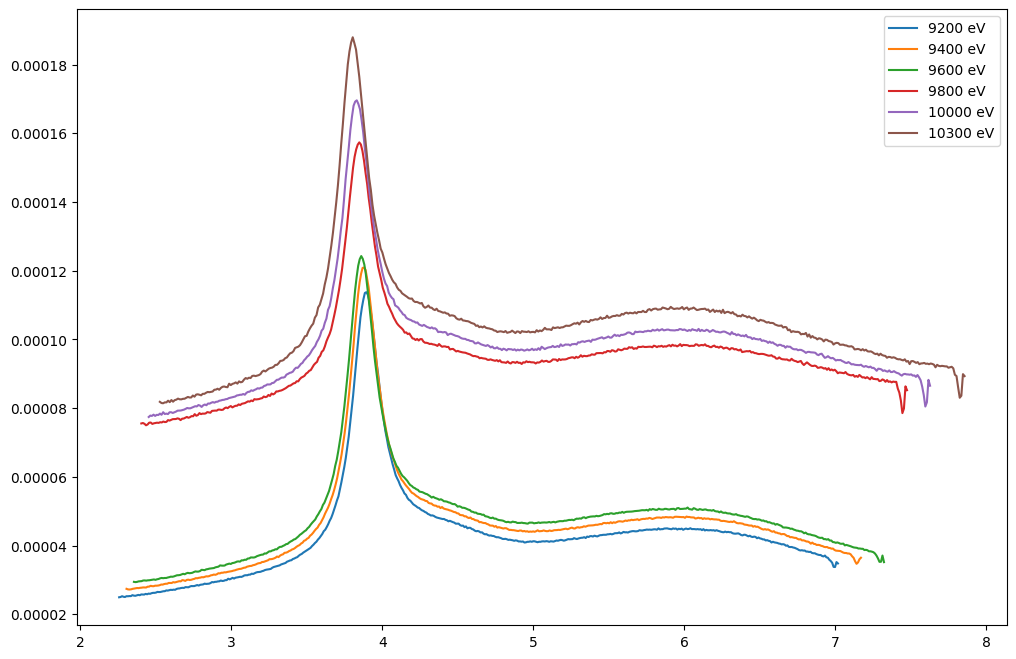

In [28]:
def showEslice(data:s1p.DafsData, e:float):
    i = data.e_slice(e)
    q = r2q(data.r, e/1e3)
    return q, i

fig, ax = plt.subplots(figsize=(12,8))
for e in (9200, 9400, 9600, 9800, 10000, 10300):
    q, i = showEslice(s202_isoA02_001, e)
    ax.plot(q, i, label=f"{e} eV")
# x = np.linspace(0.8,2.0,7)
# y = -2.2*x-5.9
# ax.plot(x,y)
# ax.set_ylim(-11,-8.5)
ax.legend()

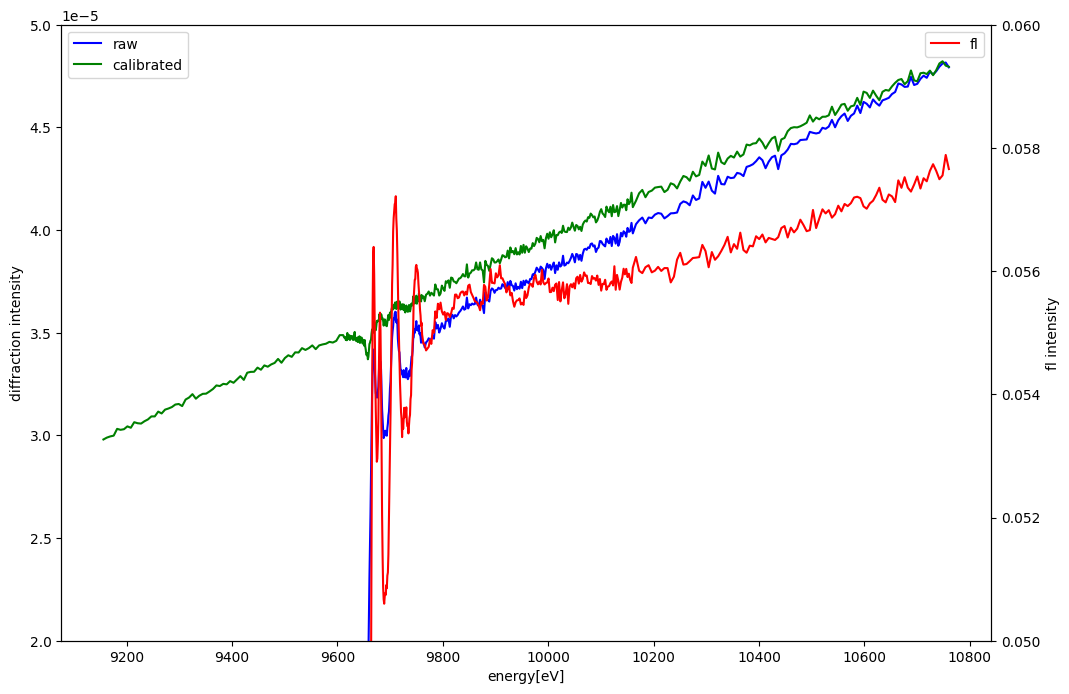

In [ ]:
q = 3
diffraction = s202_isoA02_001.q_slice(q)
fl = s202_isoA02_001.xafsfile.data["fl"] / s202_isoA02_001.i0
calibrated = diffraction - fl*0.78e-3

fig, ax1 = plt.subplots(1,1,figsize=(12,8))
ax1.plot(s202_isoA02_001.energy, diffraction-4.5e-5, label="raw", color="blue")
ax1.plot(s202_isoA02_001.energy, calibrated, label="calibrated", color="green")
ax2 = ax1.twinx()
ax2.plot(s202_isoA02_001.energy, fl, label="fl", color="red")
ax1.set_xlabel("energy[eV]")
ax1.set_ylim(2e-5,5e-5)
ax1.set_ylabel("diffraction intensity")
ax2.set_ylabel("fl intensity")
ax2.set_ylim(5e-2,6e-2)
ax1.legend()
ax2.legend()